# 简单CNN

cnn层是一个特征提取器，能提取图像信息即可

## 准备必要的库

In [12]:
# -*- coding: utf-8 -*-
# 导入PyTorch深度学习框架的核心库
import torch
# 用于计算机视觉任务的库，包含常用数据集、模型和图像变换工具
import torchvision
# 提供图像预处理和增强的工具
import torchvision.transforms as transforms
# 定义神经网络的模块
import torch.nn as nn
# 包含各种优化算法
import torch.optim as optim
# 用于绘制图表
import matplotlib.pyplot as plt
# 用于科学计算
import numpy as np
# 用于显示进度条
from tqdm import tqdm
# 用于打印模型的结构信息
from torchsummary import summary

# 设置随机种子保证可重复性
torch.manual_seed(42)

## 检查GPU是否可用

In [13]:
# 检查GPU可用性，如果有可用的GPU则使用第一个GPU（cuda:0），否则使用CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


## 1. 数据准备与预处理

In [14]:
# 定义训练集的图像预处理和增强操作
transform_train = transforms.Compose([
    # 随机裁剪图像到32x32大小，先在图像周围填充4个像素
    transforms.RandomCrop(32, padding=4),
    # 随机水平翻转图像
    transforms.RandomHorizontalFlip(),
    # 将图像转换为张量
    transforms.ToTensor(),
    # 对图像进行归一化处理
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# 定义测试集的图像预处理操作，只进行张量转换和归一化
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


## 2. 数据加载

In [ ]:
# 从torchvision中加载CIFAR - 10训练数据集
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
# 创建训练集的数据加载器，每个批次包含128个样本，每个epoch开始时打乱数据，使用2个子进程进行数据加载
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

# 从torchvision中加载CIFAR - 10测试数据集
testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
# 创建测试集的数据加载器，每个批次包含100个样本，不打乱数据，使用2个子进程进行数据加载
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

# 定义CIFAR - 10数据集中的10个类别
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## 3. 模型定义

In [16]:
# 定义一个简单的卷积神经网络类，继承自nn.Module
class SimpleCNN(nn.Module):
    def __init__(self):
        # 调用父类的构造函数
        super(SimpleCNN, self).__init__()
        # 定义特征提取部分，包含3个卷积层、ReLU激活函数和最大池化层
        self.features = nn.Sequential(
            # 输入通道数为3，输出通道数为32，卷积核大小为3，填充为1
            nn.Conv2d(3, 32, 3, padding=1),
            # ReLU激活函数
            nn.ReLU(),
            # 最大池化层，池化核大小为2，步长为2
            nn.MaxPool2d(2, 2),
            # 输入通道数为32，输出通道数为64，卷积核大小为3，填充为1
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            # 输入通道数为64，输出通道数为128，卷积核大小为3，填充为1
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        # 定义分类部分，包含一个全连接层、ReLU激活函数、Dropout层和一个输出层
        self.classifier = nn.Sequential(
            # 输入特征数为128 * 4 * 4，输出特征数为512
            nn.Linear(128 * 4 * 4, 512),
            nn.ReLU(),
            # Dropout层，丢弃率为0.5，防止过拟合
            nn.Dropout(0.5),
            # 输入特征数为512，输出特征数为10（对应10个类别）
            nn.Linear(512, 10)
        )

    def forward(self, x):
        # 通过特征提取部分
        x = self.features(x)
        # 将输出展平
        x = x.view(x.size(0), -1)
        # 通过分类部分
        x = self.classifier(x)
        return x

# 初始化模型
model = SimpleCNN().to(device)

In [17]:
# 打印模型的结构信息
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          18,496
              ReLU-5           [-1, 64, 16, 16]               0
         MaxPool2d-6             [-1, 64, 8, 8]               0
            Conv2d-7            [-1, 128, 8, 8]          73,856
              ReLU-8            [-1, 128, 8, 8]               0
         MaxPool2d-9            [-1, 128, 4, 4]               0
           Linear-10                  [-1, 512]       1,049,088
             ReLU-11                  [-1, 512]               0
          Dropout-12                  [-1, 512]               0
           Linear-13                   [-1, 10]           5,130
Total params: 1,147,466
Trainable param

## 4. 训练模型

验证阶段被放在每个 epoch 的循环之中，每完成一个 epoch 的训练，就会进行一次验证，从而实时掌握模型在验证集上的性能表现，依据验证结果对学习率加以调整。

In [18]:
# 分类问题使用交叉熵损失函数
criterion = nn.CrossEntropyLoss()

# 使用 Adam 优化器
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# 学习率调度器
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3, factor=0.5)

# 训练模型
num_epochs = 10

# 用于存储每个 epoch 的损失值和准确率
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    model.train()  # 设置模型为训练模式
    for i, (images, labels) in enumerate(tqdm(trainloader, desc=f'Epoch {epoch + 1}/{num_epochs}')):
        images, labels = images.to(device), labels.to(device)

        # 前向传播
        outputs = model(images)
        loss = criterion(outputs, labels)

        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_train_loss = running_loss / len(trainloader)
    epoch_train_accuracy = 100 * correct / total
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)
        # 验证阶段
    model.eval()  # 设置模型为评估模式
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    epoch_val_loss = val_running_loss / len(testloader)
    epoch_val_accuracy = 100 * val_correct / val_total
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_accuracy)

    # 根据验证准确率调整学习率
    scheduler.step(epoch_val_accuracy)

    # 打印训练信息
    print(f'Epoch [{epoch + 1}/{num_epochs}], '
            f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.2f}%, '
            f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_accuracy:.2f}%')

Epoch 1/10: 100%|██████████| 391/391 [00:05<00:00, 71.81it/s] 


Epoch [1/10], Train Loss: 1.6488, Train Acc: 39.02%, Val Loss: 1.2948, Val Acc: 52.94%


Epoch 2/10: 100%|██████████| 391/391 [00:04<00:00, 78.45it/s] 


Epoch [2/10], Train Loss: 1.2747, Train Acc: 53.80%, Val Loss: 1.0687, Val Acc: 62.28%


Epoch 3/10: 100%|██████████| 391/391 [00:05<00:00, 76.98it/s] 


Epoch [3/10], Train Loss: 1.1066, Train Acc: 60.83%, Val Loss: 0.9016, Val Acc: 68.05%


Epoch 4/10: 100%|██████████| 391/391 [00:05<00:00, 77.56it/s] 


Epoch [4/10], Train Loss: 0.9902, Train Acc: 65.02%, Val Loss: 0.8259, Val Acc: 70.69%


Epoch 5/10: 100%|██████████| 391/391 [00:05<00:00, 78.05it/s] 


Epoch [5/10], Train Loss: 0.9171, Train Acc: 67.68%, Val Loss: 0.8004, Val Acc: 71.96%


Epoch 6/10: 100%|██████████| 391/391 [00:05<00:00, 76.75it/s] 


Epoch [6/10], Train Loss: 0.8598, Train Acc: 70.11%, Val Loss: 0.7514, Val Acc: 74.26%


Epoch 7/10: 100%|██████████| 391/391 [00:05<00:00, 74.26it/s] 


Epoch [7/10], Train Loss: 0.8171, Train Acc: 71.40%, Val Loss: 0.7586, Val Acc: 73.56%


Epoch 8/10: 100%|██████████| 391/391 [00:05<00:00, 73.80it/s] 


Epoch [8/10], Train Loss: 0.7833, Train Acc: 72.53%, Val Loss: 0.7110, Val Acc: 75.06%


Epoch 9/10: 100%|██████████| 391/391 [00:06<00:00, 59.89it/s] 


Epoch [9/10], Train Loss: 0.7517, Train Acc: 73.71%, Val Loss: 0.7031, Val Acc: 75.96%


Epoch 10/10: 100%|██████████| 391/391 [00:06<00:00, 57.34it/s] 


Epoch [10/10], Train Loss: 0.7323, Train Acc: 74.31%, Val Loss: 0.6648, Val Acc: 76.75%


## 5. 评估模型

In [19]:
# 验证阶段
model.eval()  # 设置模型为评估模式
val_running_loss = 0.0
val_correct = 0
val_total = 0
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        val_running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        val_total += labels.size(0)
        val_correct += (predicted == labels).sum().item()

epoch_val_loss = val_running_loss / len(testloader)
epoch_val_accuracy = 100 * val_correct / val_total
val_losses.append(epoch_val_loss)
val_accuracies.append(epoch_val_accuracy)

# 根据验证准确率调整学习率
scheduler.step(epoch_val_accuracy)

# 打印训练信息
print(f'Epoch [{epoch + 1}/{num_epochs}], '
        f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.2f}%, '
        f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_accuracy:.2f}%')

Epoch [10/10], Train Loss: 0.7323, Train Acc: 74.31%, Val Loss: 0.6648, Val Acc: 76.75%


## 6. 可视化训练过程

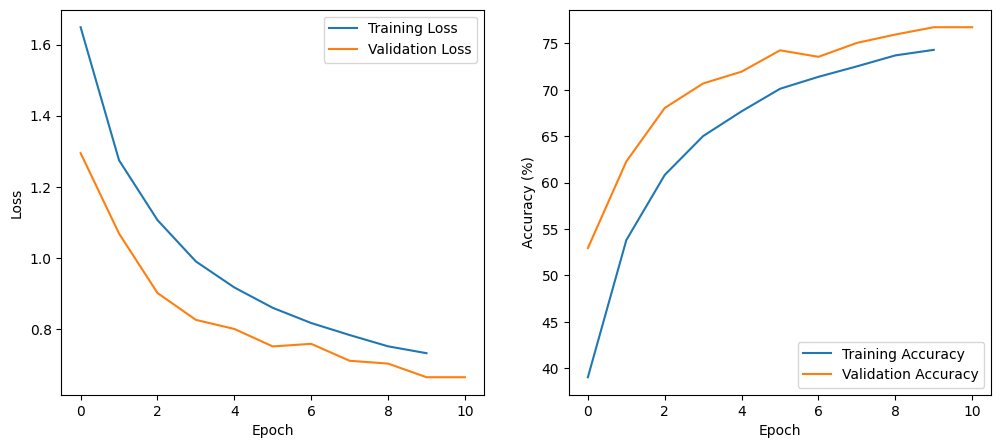

In [20]:
# 可视化训练过程
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

## 了解下数据

pytorch datasets官方文档：https://pytorch.org/vision/stable/datasets.html#cifar

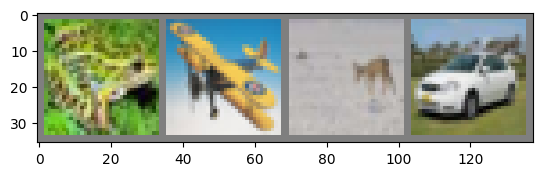

frog  plane deer  car  


In [21]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# 设置随机种子保证可重复性
torch.manual_seed(42)

# 定义图像预处理操作，这里仅进行张量转换和归一化
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 加载 CIFAR - 10 训练数据集
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=False, transform=transform)

# 创建数据加载器，每个批次包含 4 个样本
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=4, shuffle=True, num_workers=2)

# 定义类别名称，原始数据集中的类别编号为 0-9，这里定义对应的类别名称
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 函数用于反归一化并显示图像
def imshow(img):
    img = img / 2 + 0.5  # 反归一化
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# 获取一个批次的图像和标签
dataiter = iter(trainloader)
images, labels = next(dataiter)

# 显示图像
imshow(torchvision.utils.make_grid(images))

# 打印标签
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [22]:
# 获取数据集中的第一个样本
image, label = trainset[0]
# 显示图像
# imshow(torchvision.utils.make_grid(image))
# 打印图像的形状
print(f"图像的形状: {image.shape}")

图像的形状: torch.Size([3, 32, 32])


CIFAR - 10 数据集中的图像尺寸是固定的，每张图像的尺寸为 32x32 像素，并且是彩色图像，具有 3 个颜色通道（红、绿、蓝），即图像的形状为 (3, 32, 32) ，这里的 3 代表通道数，32 和 32 分别代表图像的高度和宽度。